# Data Cleaning and Prep 

In [1]:
import nltk
import matplotlib
import os
import glob
import nltk, re, pprint
import pandas as pd
from nltk import word_tokenize
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.feature_extraction.text import TfidfVectorizer
import mpld3
import gensim 
import pyLDAvis.gensim
import numpy as np

In [2]:
# use glob to get all the files that end with .txt 
textFiles = glob.glob("Books/*txt")
textFiles
type(textFiles)

list

In [3]:
# transform into dictionary so I can have access to books
d = {}
for textFile in textFiles:
    d['f{0}'.format(textFile)] = open(textFile).read()
 
d.keys()

dict_keys(['fBooks/text_38.txt', 'fBooks/text_10.txt', 'fBooks/text_264.txt', 'fBooks/text_270.txt', 'fBooks/text_258.txt', 'fBooks/text_310.txt', 'fBooks/text_304.txt', 'fBooks/text_338.txt', 'fBooks/text_112.txt', 'fBooks/text_106.txt', 'fBooks/text_107.txt', 'fBooks/text_113.txt', 'fBooks/text_339.txt', 'fBooks/text_305.txt', 'fBooks/text_311.txt', 'fBooks/text_259.txt', 'fBooks/text_271.txt', 'fBooks/text_265.txt', 'fBooks/text_11.txt', 'fBooks/text_39.txt', 'fBooks/text_13.txt', 'fBooks/text_273.txt', 'fBooks/text_267.txt', 'fBooks/text_298.txt', 'fBooks/text_307.txt', 'fBooks/text_313.txt', 'fBooks/text_105.txt', 'fBooks/text_111.txt', 'fBooks/text_139.txt', 'fBooks/text_138.txt', 'fBooks/text_110.txt', 'fBooks/text_104.txt', 'fBooks/text_312.txt', 'fBooks/text_306.txt', 'fBooks/text_299.txt', 'fBooks/text_266.txt', 'fBooks/text_272.txt', 'fBooks/text_12.txt', 'fBooks/text_16.txt', 'fBooks/text_276.txt', 'fBooks/text_262.txt', 'fBooks/text_289.txt', 'fBooks/text_302.txt', 'fBooks

In [4]:
# convert the book titles into a list
book_titles = list(d.keys())

# convert values into a list
book_text = list(d.values())

# see first items 
book_text[338][:100]

'Midnight\n\nBeverly Jenkins\n\n\n\n\n\nContents\n\nDedication\n\n\n\nPrologue\n\n\n\nChapter 1\n\n\n\nChapter 2\n\n\n\nChapter'

In [5]:
# transform book titles into a book array to add as a column to a df later
book_array = np.asarray(book_titles)
type(book_array)

numpy.ndarray

## Stopwords, stemming, lemmatizing, and tokenizing 

This section is focused on defining some functions to manipulate the synopses. First, I load NLTK's list of English stop words. Stop words are words like "a", "the", or "in" which don't convey significant meaning. I also append 'towards' as a stopwords, since it appeared as a high frequency item and had to account for spelling (toward vs towards), and 'Chapter'

In [6]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

# add towards to the list of stop words 
stopwords.append(['towards', 'Chapter'])

# check the stopwpords were added 
stopwords[-1]

['towards', 'Chapter']

Next I import the Snowball Stemmer and Lemmatizer to get to the root of the word or root meaning.

In [7]:
# load nltk's SnowballStemmer as variable 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

# import WordNetLemmatizer as variable 'lemmatizer'
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 

Below I define three functions:

* tokenize_and_stem: tokenizes (splits the synopsis into a list of its respective words (or tokens) and also stems each token
* tokenize_and_lemmatize: tokenizes (splits the synopsis into a list of its respective words (or tokens) and also lemmatizes each token
* tokenize_only: tokenizes the synopsis only

In [8]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens


def tokenize_and_lemmatize(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    lems = [lemmatizer.lemmatize(t) for t in filtered_tokens]
    return lems

In [9]:
from nltk.tag import pos_tag

#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
def strip_proppers_POS(text):
    tagged = pos_tag(text) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if word.islower() and word.isalpha() and pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

# Filter for only nouns
def noun_only(text):
    pos_comment = nltk.pos_tag(text)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

Here I run the actual text processing (removing of proper nouns, tokenization, removal of stop words)

In [10]:
from gensim import corpora, models, similarities 

#tokenize and lemmatize 
%time tokenized_text = [tokenize_and_lemmatize(text) for text in book_text]

#remove stop words
%time preprocess = [[word for word in text if word not in stopwords] for text in tokenized_text]

# remove proper nouns
%time texts = [strip_proppers_POS(doc) for doc in preprocess]

CPU times: user 7min 48s, sys: 1.52 s, total: 7min 50s
Wall time: 7min 52s
CPU times: user 45.6 s, sys: 83.3 ms, total: 45.7 s
Wall time: 45.7 s
CPU times: user 14min 28s, sys: 968 ms, total: 14min 29s
Wall time: 14min 30s


# Latent Diriechlet Allocation Models

## Latent Dirichlet Allocation¶

This section focuses on using Latent Dirichlet Allocation (LDA) to learn yet more about the hidden structure within the 339 romance novels books. LDA is a probabilistic topic model that assumes documents are a mixture of topics and that each word in the document is attributable to the document's topics.

I use Gensim's implementation, and need a dictionary and a corpus that uses bag of words. 

In [11]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

In [123]:
pickle_out2 = open("corpus.pkl", mode = "wb") 
pickle.dump(corpus, pickle_out2) 
pickle_out2.close()

## LDA model: chunking 2000 and topics 20

Chunking to 2000 instead of 1000 or 2500 gives me better perplexity and coherence score 

In [23]:
# increase the chunk size to 2000 
%time lda_mod = models.LdaModel(corpus, num_topics=20,id2word=dictionary, update_every=5, chunksize=2000, passes=100)

CPU times: user 37min 56s, sys: 33.7 s, total: 38min 29s
Wall time: 25min 41s


In [24]:
lda_mod.show_topics(20)

[(0,
  '0.011*"mountain" + 0.008*"truck" + 0.008*"wood" + 0.004*"tire" + 0.004*"bus" + 0.004*"station" + 0.004*"iron" + 0.003*"hood" + 0.003*"ol" + 0.003*"redneck"'),
 (1,
  '0.005*"duke" + 0.003*"carriage" + 0.003*"horse" + 0.003*"war" + 0.002*"cousin" + 0.002*"letter" + 0.002*"prince" + 0.002*"slave" + 0.002*"soldier" + 0.002*"servant"'),
 (2,
  '0.004*"cousin" + 0.003*"pregnant" + 0.002*"countered" + 0.002*"extended" + 0.002*"dining" + 0.002*"band" + 0.002*"uncle" + 0.002*"former" + 0.002*"protect" + 0.002*"staircase"'),
 (3,
  '0.005*"movie" + 0.005*"sofa" + 0.004*"police" + 0.004*"camera" + 0.004*"damned" + 0.003*"underneath" + 0.003*"cook" + 0.003*"officer" + 0.003*"parking" + 0.003*"huh"'),
 (4,
  '0.053*"fi" + 0.018*"al" + 0.014*"ed" + 0.013*"e" + 0.012*"fl" + 0.011*"l" + 0.008*"rst" + 0.008*"ing" + 0.008*"stil" + 0.007*"tel"'),
 (5,
  '0.003*"strolled" + 0.002*"shouted" + 0.002*"smirked" + 0.002*"winked" + 0.002*"giggled" + 0.001*"wind" + 0.001*"sank" + 0.001*"rocked" + 0.001*

In [25]:
# Compute Perplexity
print('Perplexity: ', lda_mod.log_perplexity(corpus)) 

# compute coherence
cm = gensim.models.coherencemodel.CoherenceModel(
         model=lda_mod, texts=texts,
         dictionary=dictionary, coherence='c_v')   
                                                
print('Coherence score: ', cm.get_coherence())

Perplexity:  -9.211999862835713
Coherence score:  0.42471341406125596


## LDA model: chunking 2000 and topics 25

Chunking to 2000 instead of 1000 or 2500 gives me better perplexity and coherence score 

In [12]:
# increase the topic number to 25
%time lda_mod25 = models.LdaModel(corpus, num_topics=25,id2word=dictionary, update_every=5, chunksize=2000, passes=100)

CPU times: user 36min 12s, sys: 14.9 s, total: 36min 27s
Wall time: 18min 27s


In [44]:
lda_mod25.show_topics(25, num_words = 50)

[(0,
  '0.013*"asks" + 0.006*"lean" + 0.004*"lift" + 0.004*"shrug" + 0.004*"na" + 0.004*"shit" + 0.003*"slide" + 0.003*"gon" + 0.003*"squeeze" + 0.003*"snap" + 0.003*"pause" + 0.003*"chuckle" + 0.002*"draw" + 0.002*"reply" + 0.002*"mom" + 0.002*"sits" + 0.002*"fuck" + 0.002*"raise" + 0.002*"player" + 0.002*"cross" + 0.002*"continues" + 0.002*"climb" + 0.002*"stretch" + 0.002*"rise" + 0.002*"campaign" + 0.002*"dick" + 0.002*"swallow" + 0.002*"shift" + 0.002*"groan" + 0.002*"shoot" + 0.002*"jerk" + 0.002*"season" + 0.002*"blink" + 0.002*"leaf" + 0.002*"bend" + 0.002*"camera" + 0.002*"twist" + 0.002*"yell" + 0.002*"toss" + 0.002*"tilt" + 0.002*"tug" + 0.002*"land" + 0.002*"couch" + 0.002*"brush" + 0.001*"yeah" + 0.001*"song" + 0.001*"drag" + 0.001*"narrow" + 0.001*"study" + 0.001*"mutter"'),
 (1,
  '0.029*"duke" + 0.006*"countess" + 0.004*"thief" + 0.004*"carriage" + 0.004*"soldier" + 0.003*"viscount" + 0.003*"pianoforte" + 0.003*"barrister" + 0.003*"vicar" + 0.003*"lord" + 0.003*"letter"

In [14]:
# Compute Perplexity
print('Perplexity: ', lda_mod25.log_perplexity(corpus)) 

# compute coherence
cm = gensim.models.coherencemodel.CoherenceModel(
         model=lda_mod25, texts=texts,
         dictionary=dictionary, coherence='c_v')   
                                                
print('Coherence score: ', cm.get_coherence())

Perplexity:  -9.271839005447882
Coherence score:  0.4604030262002477


## LDA model: chunking 2000 and topics 30

Chunking to 2000 instead of 1000 or 2500 gives me better perplexity and coherence score 

In [29]:
# increase the topic number to 30
%time lda_mod30 = models.LdaModel(corpus, num_topics=30,id2word=dictionary, update_every=5, chunksize=2000, passes=100)

CPU times: user 38min 4s, sys: 19.6 s, total: 38min 23s
Wall time: 52min 39s


In [30]:
lda_mod30.show_topics(30)

[(0,
  '0.010*"although" + 0.006*"sexual" + 0.005*"pregnant" + 0.005*"cousin" + 0.005*"discovered" + 0.004*"aunt" + 0.004*"affair" + 0.004*"grandfather" + 0.004*"uncle" + 0.004*"beer"'),
 (1,
  '0.000*"fi" + 0.000*"shit" + 0.000*"dad" + 0.000*"apartment" + 0.000*"fucking" + 0.000*"fuck" + 0.000*"cake" + 0.000*"truck" + 0.000*"na" + 0.000*"hospital"'),
 (2,
  '0.002*"despite" + 0.001*"murmured" + 0.001*"tea" + 0.001*"prince" + 0.001*"photo" + 0.001*"project" + 0.001*"jerked" + 0.001*"fingertip" + 0.001*"likely" + 0.001*"muttered"'),
 (3,
  '0.000*"shit" + 0.000*"mom" + 0.000*"fucking" + 0.000*"hospital" + 0.000*"apartment" + 0.000*"pregnant" + 0.000*"na" + 0.000*"cousin" + 0.000*"weekend" + 0.000*"text"'),
 (4,
  '0.000*"shit" + 0.000*"fuck" + 0.000*"text" + 0.000*"couch" + 0.000*"na" + 0.000*"apartment" + 0.000*"hospital" + 0.000*"police" + 0.000*"college" + 0.000*"partner"'),
 (5,
  '0.012*"cake" + 0.011*"weekend" + 0.011*"text" + 0.009*"couch" + 0.008*"cupcake" + 0.006*"elevator" + 0

In [31]:
# Compute Perplexity
print('Perplexity: ', lda_mod30.log_perplexity(corpus)) 

# compute coherence
cm = gensim.models.coherencemodel.CoherenceModel(
         model=lda_mod30, texts=texts,
         dictionary=dictionary, coherence='c_v')   
                                                
print('Coherence score: ', cm.get_coherence())

Perplexity:  -9.359900223339398
Coherence score:  0.3910419326242234


## LDA model: chunking 2000 and topics 35

Chunking to 2000 instead of 1000 or 2500 gives me better perplexity and coherence score 

In [32]:
# increase the topic number to 35
%time lda_mod35 = models.LdaModel(corpus, num_topics=35,id2word=dictionary, update_every=5, chunksize=2000, passes=100)

CPU times: user 1h 5min 12s, sys: 44.7 s, total: 1h 5min 57s
Wall time: 33min 48s


In [33]:
lda_mod35.show_topics(35)

[(0,
  '0.011*"asks" + 0.005*"lean" + 0.003*"lift" + 0.003*"shit" + 0.003*"shrug" + 0.003*"na" + 0.003*"slide" + 0.002*"squeeze" + 0.002*"gon" + 0.002*"snap"'),
 (1,
  '0.004*"strolled" + 0.002*"shouted" + 0.002*"smirked" + 0.002*"winked" + 0.002*"wind" + 0.002*"giggled" + 0.002*"sank" + 0.001*"elevator" + 0.001*"eyed" + 0.001*"rocked"'),
 (2,
  '0.004*"pressroom" + 0.004*"dolyn" + 0.002*"gawky" + 0.002*"oored" + 0.002*"exclaim" + 0.001*"suckles" + 0.001*"superstardom" + 0.000*"macchiato" + 0.000*"sportscaster" + 0.000*"audition"'),
 (3,
  '0.004*"sofa" + 0.003*"police" + 0.002*"hospital" + 0.002*"movie" + 0.002*"elevator" + 0.002*"parking" + 0.002*"player" + 0.002*"lawyer" + 0.002*"reporter" + 0.001*"client"'),
 (4,
  '0.007*"although" + 0.004*"sexual" + 0.004*"discovered" + 0.003*"pregnant" + 0.003*"cousin" + 0.003*"affair" + 0.003*"aunt" + 0.003*"grandfather" + 0.003*"uncle" + 0.003*"hospital"'),
 (5,
  '0.000*"gon" + 0.000*"shit" + 0.000*"fuck" + 0.000*"na" + 0.000*"dick" + 0.000*"

In [34]:
# Compute Perplexity
print('Perplexity: ', lda_mod35.log_perplexity(corpus)) 

# compute coherence
cm = gensim.models.coherencemodel.CoherenceModel(
         model=lda_mod35, texts=texts,
         dictionary=dictionary, coherence='c_v')   
                                                
print('Coherence score: ', cm.get_coherence())

Perplexity:  -9.468474360076442
Coherence score:  0.4333991983247065


## LDA model: chunking 2000 and topics 40

Chunking to 2000 instead of 1000 or 2500 gives me better perplexity and coherence score 

In [35]:
# increase the topic number to 40
%time lda_mod40 = models.LdaModel(corpus, num_topics=40,id2word=dictionary, update_every=5, chunksize=2000, passes=100)

CPU times: user 1h 18min 57s, sys: 22.8 s, total: 1h 19min 20s
Wall time: 40min 1s


In [36]:
lda_mod40.show_topics(40)

[(0,
  '0.006*"cock" + 0.005*"murmured" + 0.004*"pussy" + 0.003*"lust" + 0.003*"jerked" + 0.002*"harsh" + 0.002*"muttered" + 0.002*"clit" + 0.002*"fuck" + 0.002*"caress"'),
 (1,
  '0.008*"snow" + 0.006*"cat" + 0.005*"realise" + 0.004*"realised" + 0.004*"blizzard" + 0.004*"gin" + 0.003*"occurred" + 0.003*"affection" + 0.003*"kitten" + 0.003*"fucking"'),
 (2,
  '0.020*"yarn" + 0.014*"knitting" + 0.005*"damned" + 0.005*"practically" + 0.005*"hat" + 0.005*"knit" + 0.005*"neighborhood" + 0.004*"sandwich" + 0.004*"wing" + 0.004*"community"'),
 (3,
  '0.000*"shit" + 0.000*"text" + 0.000*"weekend" + 0.000*"mom" + 0.000*"club" + 0.000*"na" + 0.000*"stage" + 0.000*"movie" + 0.000*"fuck" + 0.000*"college"'),
 (4,
  '0.006*"royal" + 0.005*"prince" + 0.005*"sword" + 0.005*"perhaps" + 0.004*"photo" + 0.004*"train" + 0.004*"despite" + 0.004*"palace" + 0.003*"tea" + 0.003*"fingertip"'),
 (5,
  '0.005*"sofa" + 0.004*"towards" + 0.003*"trouser" + 0.003*"although" + 0.003*"lift" + 0.003*"tugged" + 0.003*

In [37]:
# Compute Perplexity
print('Perplexity: ', lda_mod40.log_perplexity(corpus)) 

# compute coherence
cm = gensim.models.coherencemodel.CoherenceModel(
         model=lda_mod40, texts=texts,
         dictionary=dictionary, coherence='c_v')   
                                                
print('Coherence score: ', cm.get_coherence())

Perplexity:  -9.511247449989954
Coherence score:  0.4113920630744191


# Note: After this section I'll be using only one model to run the matrices, LDA vis, and book similarity calculations.

# Topic Matrices

### Model with 20 topics

In [43]:
topics_matrix = lda_mod25.show_topics(formatted=False, num_words=50)
topics_matrix = np.array(topics_matrix)

topic_words = topics_matrix[:,1]
for i in topic_words:
    print([str(word) for word in i])
    print()

["('asks', 0.012815812)", "('lean', 0.0064843055)", "('lift', 0.004149329)", "('shrug', 0.0039221914)", "('na', 0.0037199135)", "('shit', 0.0035316488)", "('slide', 0.0032168538)", "('gon', 0.003011794)", "('squeeze', 0.002910754)", "('snap', 0.0026493836)", "('pause', 0.0026411586)", "('chuckle', 0.0026188486)", "('draw', 0.0024981655)", "('reply', 0.002495854)", "('mom', 0.002362426)", "('sits', 0.0022762504)", "('fuck', 0.0022355693)", "('raise', 0.0020884564)", "('player', 0.001970689)", "('cross', 0.00196924)", "('continues', 0.0018924002)", "('climb', 0.0018739585)", "('stretch', 0.001872)", "('rise', 0.0018584304)", "('campaign', 0.0018534368)", "('dick', 0.0018306149)", "('swallow', 0.0018127286)", "('shift', 0.0017795801)", "('groan', 0.0017686309)", "('shoot', 0.0017638323)", "('jerk', 0.0017306942)", "('season', 0.0017304843)", "('blink', 0.0016736394)", "('leaf', 0.0016580401)", "('bend', 0.0016578464)", "('camera', 0.0016502553)", "('twist', 0.0016251119)", "('yell', 0.001

# Visualizing and Interpreting Topics

### Topics with 25 models

In [111]:
# visualize topics 
import pyLDAvis.gensim 
pyLDAvis.enable_notebook()
lda_visualization = pyLDAvis.gensim.prepare(lda_mod25, corpus, dictionary, sort_topics=False)

In [114]:
lda_visualization

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.079241 -0.009530       1        1   4.375992
1      0.025483  0.188533       2        1   0.835712
2      0.303595 -0.017270       3        1   0.000548
3     -0.027791  0.093092       4        1   1.717777
4     -0.059097 -0.030060       5        1  13.491711
5     -0.045359 -0.115133       6        1   0.796774
6     -0.045252  0.019191       7        1   8.179163
7     -0.023633  0.000295       8        1   1.070504
8     -0.035572  0.180145       9        1   3.114832
9     -0.117846  0.009485      10        1   4.407438
10    -0.090680  0.021104      11        1   5.172240
11    -0.098112 -0.014290      12        1   2.685383
12    -0.032305 -0.147500      13        1   0.803816
13    -0.088506 -0.006824      14        1  12.749254
14     0.303595 -0.017270      15        1   0.000548
15     0.303595 -0.017270      16        1   0.000548
16    -0.033916  0.095973      17        1  11.681691
17    -0.101945 -0.070421      18        1   2.946341
18     0.303596 -0.017270      19        1   0.000548
19    -0.078309 -0.021437      20        1   2.076991
20    -0.087060 -0.082738      21        1   1.752477
21    -0.084959 -0.105752      22        1   3.961906
22    -0.064403  0.031301      23        1   9.429220
23    -0.054144  0.088252      24        1   7.771861
24     0.008264 -0.054608      25        1   0.976726, topic_info=              Term         Freq        Total Category  logprob  loglift
8439          shit  6513.000000  6513.000000  Default  30.0000  30.0000
22564           fi  1854.000000  1854.000000  Default  29.0000  29.0000
7284          fuck  4122.000000  4122.000000  Default  28.0000  28.0000
7348           gon  3675.000000  3675.000000  Default  27.0000  27.0000
7878            na  3824.000000  3824.000000  Default  26.0000  26.0000
11351        nigga  1371.000000  1371.000000  Default  25.0000  25.0000
3372          asks  1499.000000  1499.000000  Default  24.0000  24.0000
6911          dick  2304.000000  2304.000000  Default  23.0000  23.0000
101      apartment  2968.000000  2968.000000  Default  22.0000  22.0000
1799           mom  2924.000000  2924.000000  Default  21.0000  21.0000
9468          duke   881.000000   881.000000  Default  20.0000  20.0000
7286       fucking  3412.000000  3412.000000  Default  19.0000  19.0000
2734         stage  1724.000000  1724.000000  Default  18.0000  18.0000
13978           yo  1018.000000  1018.000000  Default  17.0000  17.0000
6231           wit  1294.000000  1294.000000  Default  16.0000  16.0000
6662          club  2215.000000  2215.000000  Default  15.0000  15.0000
8174         pussy  1753.000000  1753.000000  Default  14.0000  14.0000
3064         truck  2126.000000  2126.000000  Default  13.0000  13.0000
721            dad  2364.000000  2364.000000  Default  12.0000  12.0000
3587          cock  1644.000000  1644.000000  Default  11.0000  11.0000
2748        stated   923.000000   923.000000  Default  10.0000  10.0000
297          bitch  1860.000000  1860.000000  Default   9.0000   9.0000
3293        yelled  1525.000000  1525.000000  Default   8.0000   8.0000
2674          song  1841.000000  1841.000000  Default   7.0000   7.0000
8957           wan  1157.000000  1157.000000  Default   6.0000   6.0000
659          couch  2392.000000  2392.000000  Default   5.0000   5.0000
2806      strolled   889.000000   889.000000  Default   4.0000   4.0000
4532    questioned   874.000000   874.000000  Default   3.0000   3.0000
1280   grandmother  1567.000000  1567.000000  Default   2.0000   2.0000
6135       towards  1099.000000  1099.000000  Default   1.0000   1.0000
...            ...          ...          ...      ...      ...      ...
39032          fel    33.084169    33.872196  Topic25  -6.6049   4.6052
38960          cel    32.139898    32.927925  Topic25  -6.6339   4.6045
39146         smel    31.195636    31.983663  Topic

In [98]:
pyLDAvis.save_html(lda_visualization, 'vis.html')

# Heatmap comparing book topics

Source/inspo: https://github.com/FelixChop/MediumArticles/blob/master/LDA-BBC.ipynb

In [22]:
# get topics for every book 
topics = [lda_mod25[corpus[i]] for i in range(len(book_text))]

# define function to get the topics into a df 
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(25))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

# test function 
topics_document_to_dataframe([(9, 0.03853655432967504), (15, 0.09130117862212643), (18, 0.8692868808484044)], 20)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0385366,...,0.0913012,NaN,NaN,0.869287,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
# create a matrix of topic weighting, with documents as rows and topics as columns
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=25) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

document_topic.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.000000,0.0,0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.013127,...,0,0.014661,0.0,0,0.972084,0.0,0.0,0.000000,0.000000,0.0
1,0.000000,0.0,0,0.0,0.037392,0.0,0.027640,0.0,0.000000,0.000000,...,0,0.032717,0.0,0,0.000000,0.0,0.0,0.085729,0.069290,0.0
2,0.000000,0.0,0,0.0,0.022387,0.0,0.056547,0.0,0.000000,0.000000,...,0,0.000000,0.0,0,0.000000,0.0,0.0,0.000000,0.791586,0.0
3,0.476382,0.0,0,0.0,0.016844,0.0,0.000000,0.0,0.000000,0.000000,...,0,0.038324,0.0,0,0.000000,0.0,0.0,0.000000,0.441977,0.0
4,0.000000,0.0,0,0.0,0.264202,0.0,0.000000,0.0,0.018515,0.066652,...,0,0.068169,0.0,0,0.000000,0.0,0.0,0.386018,0.096222,0.0


### Visualize the topics in each book

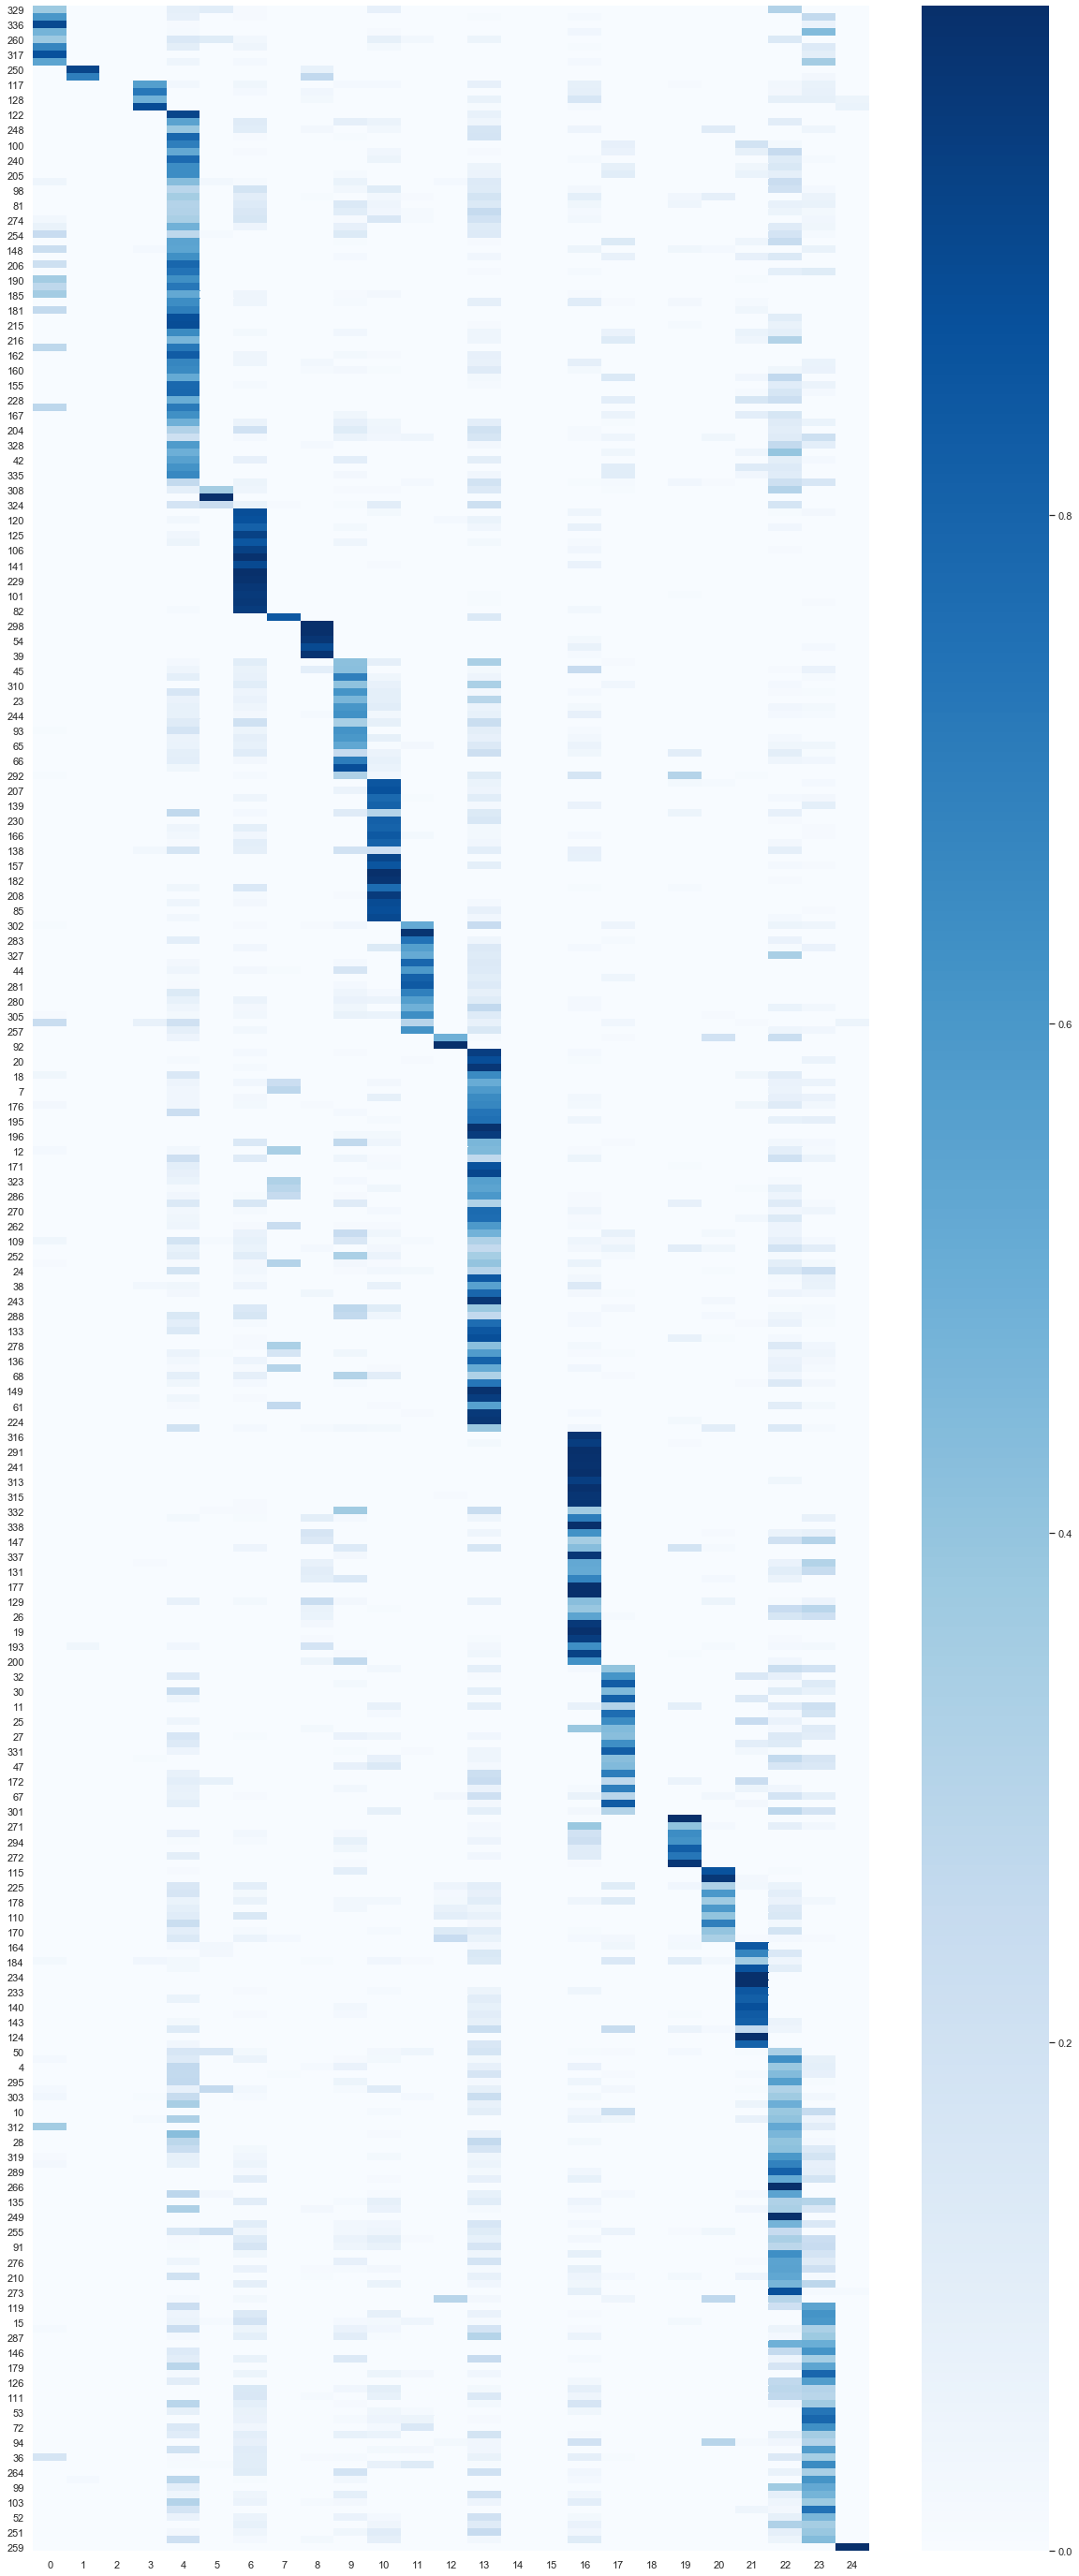

In [57]:
%matplotlib inline
import seaborn as sns; sns.set(rc={'figure.figsize':(20,50)})
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index], cmap = 'Blues')

In [60]:
document_topic2 = document_topic

In [61]:
document_topic.sort_values(14, ascending=False)[14].head(5)

0      0
223    0
231    0
230    0
229    0
Name: 14, dtype: int64

In [62]:
# define function to get the numbers from rows with strings 
def find_number(text):
    num = re.findall(r'[0-9]+',text)
    return " ".join(num)

In [63]:
document_topic['standard_title'] = book_array

document_topic['book_title_number'] = document_topic['standard_title'].apply(lambda x: find_number(x))

document_topic.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,standard_title,book_title_number
0,0.000000,0.0,0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.013127,...,0.0,0,0.972084,0.0,0.0,0.000000,0.000000,0.0,fBooks/text_38.txt,38
1,0.000000,0.0,0,0.0,0.037392,0.0,0.027640,0.0,0.000000,0.000000,...,0.0,0,0.000000,0.0,0.0,0.085729,0.069290,0.0,fBooks/text_10.txt,10
2,0.000000,0.0,0,0.0,0.022387,0.0,0.056547,0.0,0.000000,0.000000,...,0.0,0,0.000000,0.0,0.0,0.000000,0.791586,0.0,fBooks/text_264.txt,264
3,0.476382,0.0,0,0.0,0.016844,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0,0.000000,0.0,0.0,0.000000,0.441977,0.0,fBooks/text_270.txt,270
4,0.000000,0.0,0,0.0,0.264202,0.0,0.000000,0.0,0.018515,0.066652,...,0.0,0,0.000000,0.0,0.0,0.386018,0.096222,0.0,fBooks/text_258.txt,258


In [64]:
# read csv file with the book metadata 
book_metadata = pd.read_csv('List of Authors - Books.csv')

#book_metadata = book_metadata.set_index('file_number')

book_metadata['book_title_number'] = book_metadata['file_number'].apply(str)

book_metadata.head()

,Author,Book,file_number,Filename,Year published,Number of pages,book_title_number
0,Alyssa Cole,A duke by default,1,text_1.txt,2018.0,385.0,1
1,Alyssa Cole,A hope divided,2,text_2.txt,2017.0,349.0,2
2,Alyssa Cole,A prince on paper,3,text_3.txt,2019.0,335.0,3
3,Alyssa Cole,A princess in theory,4,text_4.txt,2018.0,221.0,4
4,Alyssa Cole,An extraordinary union,5,text_5.txt,2017.0,292.0,5


In [65]:
book_df = document_topic.merge(book_metadata, how='outer', right_on = 'book_title_number', left_on = 'book_title_number')

book_df = book_df.set_index('Book')

book_df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,standard_title,book_title_number,Author,file_number,Filename,Year published,Number of pages
Book,,,,,,,,,,,,,,,,,,,,,
Stepping to a new day,0.000000,0.0,0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.013127,...,0.000000,0.000000,0.0,fBooks/text_38.txt,38,Beverly Jenkins,38,NaN,2016.0,152.0
Her lovers legacy,0.000000,0.0,0,0.0,0.037392,0.0,0.027640,0.0,0.000000,0.000000,...,0.085729,0.069290,0.0,fBooks/text_10.txt,10,Adrianne Byrd,10,text_10.txt,2008.0,249.0
Island fling,0.000000,0.0,0,0.0,0.022387,0.0,0.056547,0.0,0.000000,0.000000,...,0.000000,0.791586,0.0,fBooks/text_264.txt,264,Therese Beharrie,264,NaN,NaN,NaN
The kingmaker,0.476382,0.0,0,0.0,0.016844,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.441977,0.0,fBooks/text_270.txt,270,Kennedy Ryan,270,NaN,NaN,NaN
The write escape,0.000000,0.0,0,0.0,0.264202,0.0,0.000000,0.0,0.018515,0.066652,...,0.386018,0.096222,0.0,fBooks/text_258.txt,258,Charish Reid,258,NaN,NaN,NaN


In [66]:
book_viz = book_df[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
                    22, 23, 24, 'Author']]

book_viz

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,Author
Book,,,,,,,,,,,,,,,,,,,,,
Stepping to a new day,0.000000,0.0,0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013127,...,0.014661,0.000000,0,0.972084,0.000000,0.000000,0.000000,0.000000,0.0,Beverly Jenkins
Her lovers legacy,0.000000,0.0,0,0.00000,0.037392,0.000000,0.027640,0.000000,0.000000,0.000000,...,0.032717,0.000000,0,0.000000,0.000000,0.000000,0.085729,0.069290,0.0,Adrianne Byrd
Island fling,0.000000,0.0,0,0.00000,0.022387,0.000000,0.056547,0.000000,0.000000,0.000000,...,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.791586,0.0,Therese Beharrie
The kingmaker,0.476382,0.0,0,0.00000,0.016844,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.038324,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.441977,0.0,Kennedy Ryan
The write escape,0.000000,0.0,0,0.00000,0.264202,0.000000,0.000000,0.000000,0.018515,0.066652,...,0.068169,0.000000,0,0.000000,0.000000,0.000000,0.386018,0.096222,0.0,Charish Reid
Higher love,0.000000,0.0,0,0.00000,0.076150,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.703095,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,Alexandria House
Go deep,0.000000,0.0,0,0.00000,0.345684,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0,0.000000,0.000000,0.056977,0.499750,0.000000,0.0,Rilzy Adams
The sweetest surrender,0.000000,0.0,0,0.00000,0.037306,0.000000,0.000000,0.278164,0.000000,0.000000,...,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.059815,0.000000,0.0,Stephanie Nicole Norris
His diamond queen,0.000000,0.0,0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.021211,0.405037,0,0.000000,0.000000,0.000000,0.228810,0.193430,0.0,Lena Hart


In [67]:
book_viz['max_val'] = book_viz[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                                17, 18, 19, 20, 21,22, 23, 24]].max(axis=1)
book_viz['max_col'] = book_viz[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                                       17, 18, 19, 20, 21, 22, 23, 24]].idxmax(axis=1)

#document_topic['second_largest'] = document_topic.apply(lambda row: row.nlargest(2).values[-1],axis=1)
book_viz

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,Author,max_val,max_col
Book,,,,,,,,,,,,,,,,,,,,,
Stepping to a new day,0.000000,0.0,0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013127,...,0,0.972084,0.000000,0.000000,0.000000,0.000000,0.0,Beverly Jenkins,0.972084,19
Her lovers legacy,0.000000,0.0,0,0.00000,0.037392,0.000000,0.027640,0.000000,0.000000,0.000000,...,0,0.000000,0.000000,0.000000,0.085729,0.069290,0.0,Adrianne Byrd,0.650178,13
Island fling,0.000000,0.0,0,0.00000,0.022387,0.000000,0.056547,0.000000,0.000000,0.000000,...,0,0.000000,0.000000,0.000000,0.000000,0.791586,0.0,Therese Beharrie,0.791586,23
The kingmaker,0.476382,0.0,0,0.00000,0.016844,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0.000000,0.000000,0.000000,0.000000,0.441977,0.0,Kennedy Ryan,0.476382,0
The write escape,0.000000,0.0,0,0.00000,0.264202,0.000000,0.000000,0.000000,0.018515,0.066652,...,0,0.000000,0.000000,0.000000,0.386018,0.096222,0.0,Charish Reid,0.386018,22
Higher love,0.000000,0.0,0,0.00000,0.076150,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,Alexandria House,0.703095,17
Go deep,0.000000,0.0,0,0.00000,0.345684,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0.000000,0.000000,0.056977,0.499750,0.000000,0.0,Rilzy Adams,0.499750,22
The sweetest surrender,0.000000,0.0,0,0.00000,0.037306,0.000000,0.000000,0.278164,0.000000,0.000000,...,0,0.000000,0.000000,0.000000,0.059815,0.000000,0.0,Stephanie Nicole Norris,0.589026,13
His diamond queen,0.000000,0.0,0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0.000000,0.000000,0.000000,0.228810,0.193430,0.0,Lena Hart,0.405037,17


In [68]:
bookData = book_viz.reset_index()
bookData = bookData.reset_index()

bookData.to_csv('books.csv')

# Book recommendation based on LDA

In [120]:
import itertools 

# define functions 
bookList = bookData['Book']
bookIndex = bookData['index']
bookAuthor = bookData['Author']
index2 = similarities.MatrixSimilarity(lda_mod25[corpus])


#userSelection = 6
userSelection = input("Hey, please enter the book you would like to find similar books for: ")

#listOfRelatedBooks = []
corpus_to_compare = []
names_of_related_books = []
identifiedTopic = 55

for book in range(1, 339):
    if userSelection == bookList[book]:
          corpusA = corpus[bookIndex[book]]
          vec_lda = lda_mod25[corpusA]
          corpus_to_compare.append(vec_lda)

sim = index2[vec_lda]
sims = sorted(enumerate(sim), key=lambda item: -item[1])
DoublelistOfRelatedBooks = [list(group) for val, group in itertools.groupby(sims, lambda x: x[1] >= .97) if val]
listOfRelatedBooks = DoublelistOfRelatedBooks[0]

# split tuples into two lists with book name and similarity score 
book_name, score = map(list, zip(*listOfRelatedBooks))

# iterate to get the name of the books and not the book index 
for book in book_name:
     if (bookIndex[book]== book_name).any():
        names_of_related_books.append(bookList[book])
        names_of_related_books.append(' by ' + str(bookAuthor[book]) + '\n')

print("Here's your list:" + '\n' + ''.join(names_of_related_books) + ' ')

print('Happy reading!')


Hey, please enter the book you would like to find similar books for: Wonder
Here's your list:
Wonder by Christina C Jones
Go deep by Rilzy Adams
 
Happy reading!


# T-SNE

In [100]:
lda_mod25.print_topics()

[(15,
  '0.000*"shit" + 0.000*"fuck" + 0.000*"na" + 0.000*"song" + 0.000*"fucking" + 0.000*"dick" + 0.000*"cock" + 0.000*"camera" + 0.000*"pussy" + 0.000*"gon"'),
 (12,
  '0.008*"seizure" + 0.008*"wheeled" + 0.008*"apartment" + 0.007*"song" + 0.006*"wheelchair" + 0.006*"computer" + 0.005*"hurried" + 0.005*"medicine" + 0.004*"crutch" + 0.004*"god"'),
 (20,
  '0.005*"hurried" + 0.004*"bus" + 0.003*"towards" + 0.003*"song" + 0.003*"lightly" + 0.002*"honey" + 0.002*"elevator" + 0.002*"tea" + 0.002*"hospital" + 0.002*"nurse"'),
 (10,
  '0.005*"although" + 0.003*"sexual" + 0.003*"discovered" + 0.002*"cousin" + 0.002*"affair" + 0.002*"grandfather" + 0.002*"sofa" + 0.002*"weekend" + 0.002*"pregnant" + 0.002*"aunt"'),
 (7,
  '0.010*"strolled" + 0.007*"smirked" + 0.004*"wind" + 0.004*"sank" + 0.004*"chill" + 0.004*"pussy" + 0.004*"eyed" + 0.003*"blushed" + 0.003*"shouted" + 0.003*"sailed"'),
 (1,
  '0.029*"duke" + 0.006*"countess" + 0.004*"thief" + 0.004*"carriage" + 0.004*"soldier" + 0.003*"vis

In [110]:
import numpy as np

hm = np.array([[y for (x,y) in lda_mod25[corpus[i]]] for i in range(len(corpus))])
X = np.vstack(hm)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [104]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=2017, perplexity=30, early_exaggeration=120)
embedding = tsne.fit_transform(hm)
embedding = pd.DataFrame(embedding, columns=['x','y'])
embedding['hue'] = hm.argmax(axis=1)

ValueError: setting an array element with a sequence.

# Model using Mallet

So far I've been using Gensim to get the topics. In this section I use Mallet to compare results.

In [295]:
import os
from gensim.models.wrappers import LdaMallet

os.environ['MALLET_HOME'] = '/Users/vclugoar/new_mallet/mallet-2.0.8/'

mallet_path = '/Users/vclugoar/new_mallet/mallet-2.0.8/bin/mallet'

print ("Hello")

mallet_lda = gensim.models.wrappers.ldamallet.LdaMallet(mallet_path, corpus, dictionary, optimize_interval=10, prefix = 'm_')

Hello


CalledProcessError: Command '/Users/vclugoar/new_mallet/mallet-2.0.8/bin/mallet train-topics --input m_corpus.mallet --num-topics Dictionary(41770 unique tokens: ['abandoned', 'abhor', 'ability', 'abject', 'abuela']...)  --alpha 50 --optimize-interval 10 --num-threads 4 --output-state m_state.mallet.gz --output-doc-topics m_doctopics.txt --output-topic-keys m_topickeys.txt --num-iterations 1000 --inferencer-filename m_inferencer.mallet --doc-topics-threshold 0.0  --random-seed 0' returned non-zero exit status 2.

In [167]:
mallet_topics = mallet_lda.show_topics(20)

NameError: name 'mallet_lda' is not defined

In [121]:
lda_mod25.save('model25')

In [122]:
import pickle 
pickle_out = open("lda.pkl", mode = "wb") 
pickle.dump(lda_mod25, pickle_out) 
pickle_out.close()